#Importing Libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Initialize GPU Connection

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Ensure GPU is enabled in Colab and TensorFlow uses it
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available for TensorFlow!")
else:
    print("No GPU found. Running on CPU.")

# Optional: Set memory growth to prevent TensorFlow from allocating all GPU memory
for gpu in gpu_available:
    tf.config.experimental.set_memory_growth(gpu, True)

# Configure TensorFlow settings for optimal GPU usage
# Enable mixed precision training for faster computation
from tensorflow.keras import mixed_precision

# Set the policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed Precision Training Enabled.")

# Enable XLA (Accelerated Linear Algebra) to optimize computations
tf.config.optimizer.set_jit(True)  # Enable XLA

# Configure threading for parallel data loading (adjust this as needed)
AUTOTUNE = tf.data.AUTOTUNE

# Set the number of CPU threads for data processing
num_threads = 8  # You can adjust this depending on your CPU.

# Function to optimize the dataset pipeline
def optimize_data_pipeline(dataset, batch_size=32):
    """
    Optimize the tf.data.Dataset pipeline by applying cache, prefetch, and parallel processing.
    """
    dataset = dataset.cache()  # Cache the data if it fits in memory
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)  # Prefetch data for asynchronous loading
    dataset = dataset.map(lambda x, y: (x, y), num_parallel_calls=num_threads)  # Use multiple threads for preprocessing

    return dataset

# Define paths to your dataset directories
train_dir = '/content/drive/MyDrive/datasets/merged/train'
test_dir = '/content/drive/MyDrive/datasets/merged/test'

# Load the datasets using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,
    label_mode='categorical',  # Categorical classification (multi-class)
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,
    label_mode='categorical',  # Categorical classification (multi-class)
    shuffle=False
)

# Enable the optimizations for your training and testing datasets
train_dataset = optimize_data_pipeline(train_dataset)
test_dataset = optimize_data_pipeline(test_dataset)

# Verify TensorFlow is using the following devices (showing all available devices)
print("TensorFlow is using the following devices:")
print(tf.config.list_physical_devices())

# Run a small test to check if TensorFlow can run on GPU and use optimizations
print("Running a small test on GPU with optimizations...")
x = tf.random.normal([10000, 10000])
y = tf.matmul(x, x)
print("Test completed on:", "GPU" if gpu_available else "CPU")

# Display memory usage info to confirm optimization
if gpu_available:
    physical_devices = tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        # Extract the device name for memory info
        device_name = device.name.split(":")[-1]  # Extract GPU index part like "0" from "/physical_device:GPU:0"

        print(f"Device details: {device}")
        try:
            memory_info = tf.config.experimental.get_memory_info(f'GPU:{device_name}')
            print(f"Memory Info for GPU:{device_name}: {memory_info}")
        except Exception as e:
            print(f"Error fetching memory info for GPU:{device_name}: {e}")

No GPU found. Running on CPU.
Mixed Precision Training Enabled.
Found 21910 files belonging to 29 classes.
Found 3549 files belonging to 29 classes.
TensorFlow is using the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Running a small test on GPU with optimizations...
Test completed on: CPU


#Step 1: Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


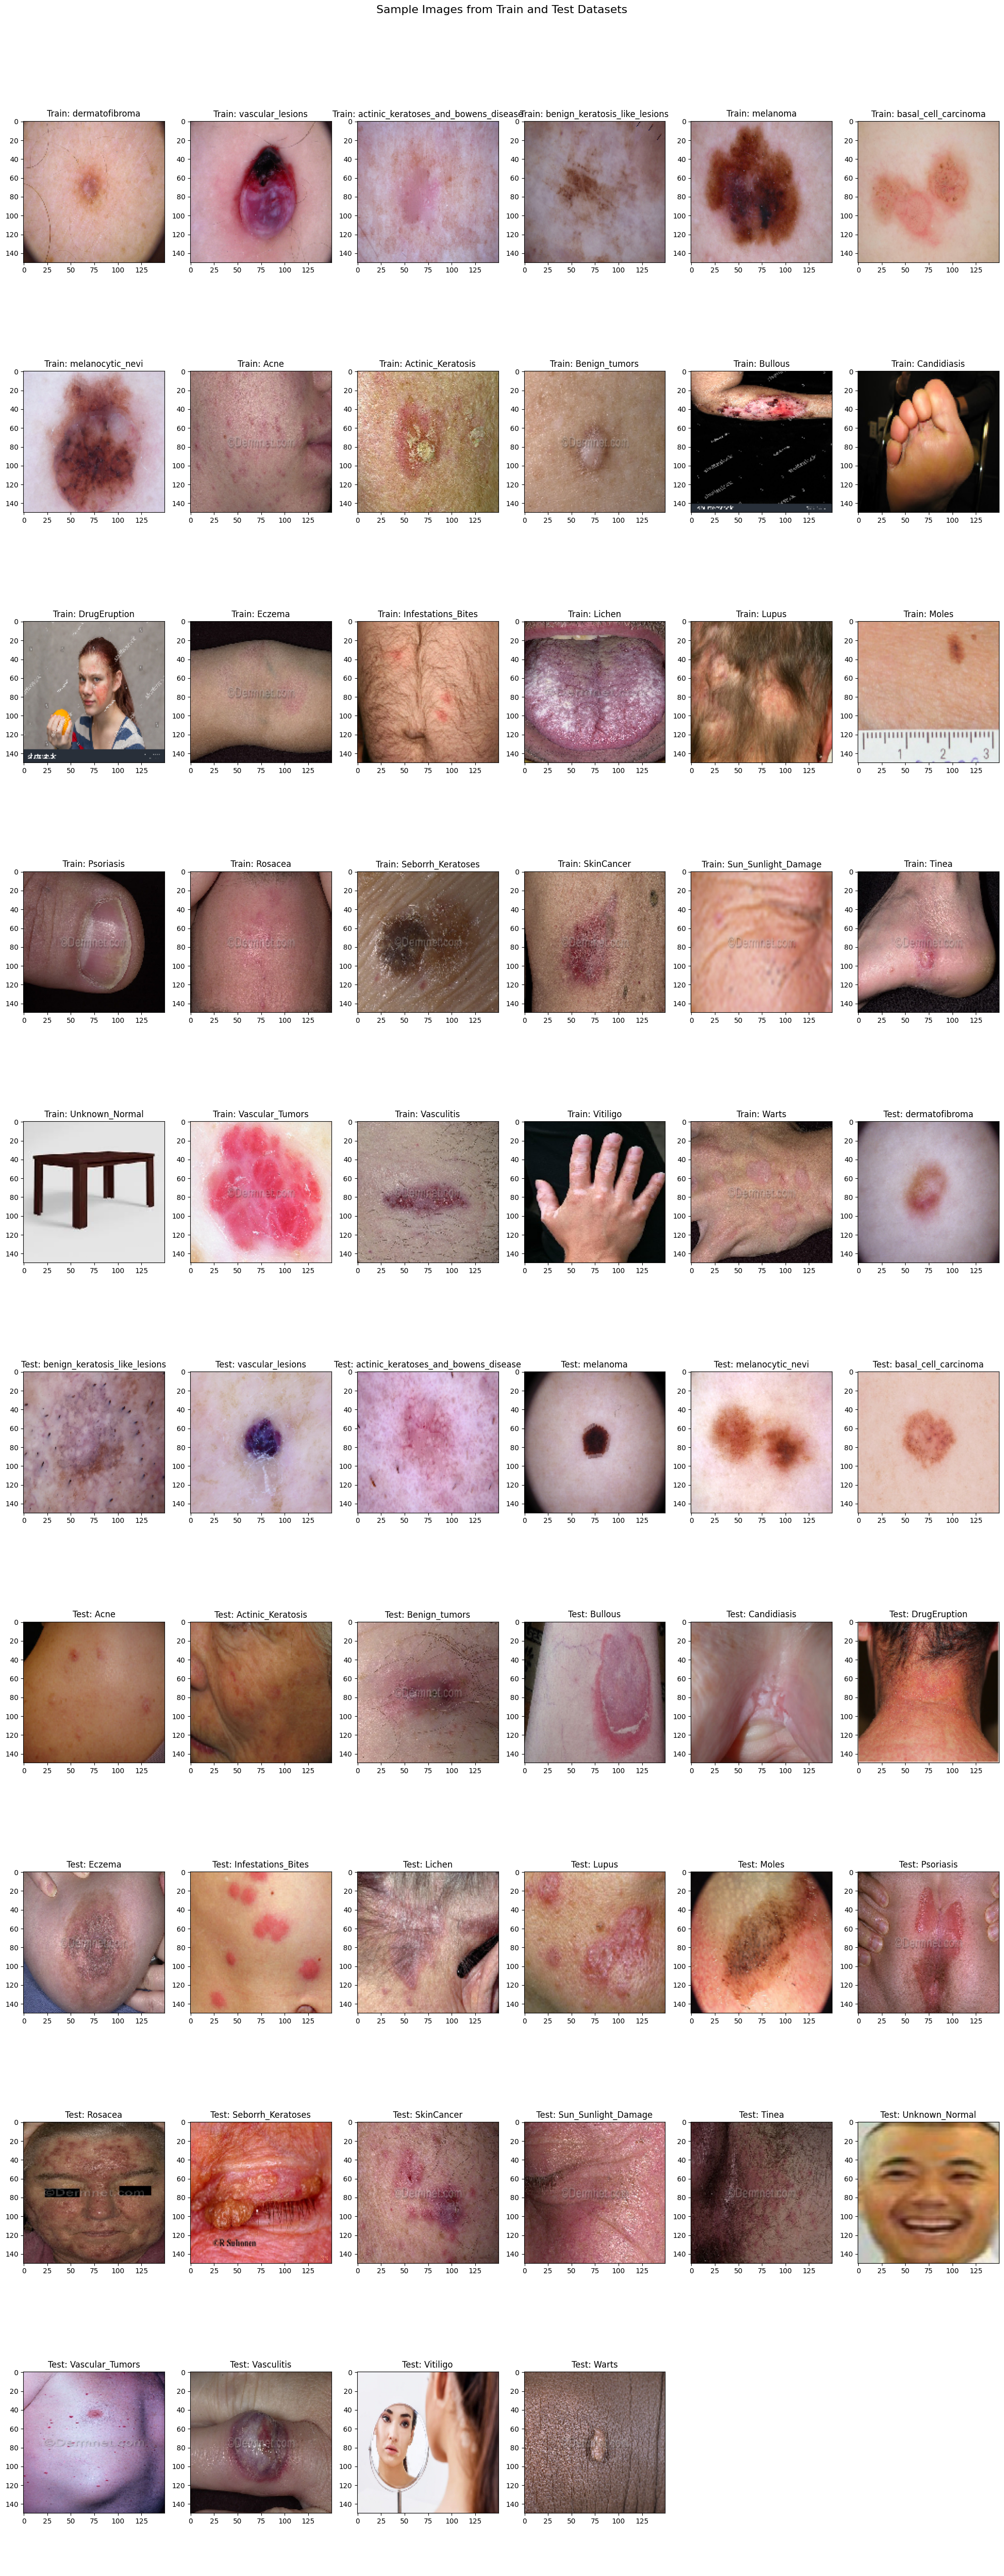

In [4]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Paths to the train and test directories
train_dir = '/content/drive/MyDrive/datasets/merged/train'
test_dir = '/content/drive/MyDrive/datasets/merged/test'

# List all subdirectories (disease classes) in the train and test directories
train_disease_classes = os.listdir(train_dir)
test_disease_classes = os.listdir(test_dir)

# Total skin disease classes are 29, so we will display images for all 29 classes from both train and test
total_images = 29  # 29 classes, 1 image per class

# Set the number of images per row (adjust this for a nice grid layout)
ncols = 6  # Number of columns in the grid
nrows = (2 * total_images // ncols) + (1 if (2 * total_images) % ncols else 0)  # Adjust rows to fit all images

# Create a grid to display the images for both train and test
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
ax = ax.ravel()  # Flatten the axis array to make it easier to index

# Keep track of the index for placing images on the grid
idx = 0

# Display the train images (1 image per disease)
for disease_class in train_disease_classes[:total_images]:  # Limit to the first 29 classes
    disease_class_path = os.path.join(train_dir, disease_class)

    # List the image files in the disease class directory
    image_files = os.listdir(disease_class_path)

    # Get the first image file (since we only want 1 image per class)
    sample_image = image_files[0]

    # Get the full path of the image file
    img_path = os.path.join(disease_class_path, sample_image)

    # Load the image (Resize to smaller size, e.g., 150x150)
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to smaller size (150x150)

    # Convert image to array for visualization
    img_array = image.img_to_array(img) / 255.0  # Normalize the image (same as ImageDataGenerator)

    # Plot the image on the grid
    ax[idx].imshow(img_array)
    ax[idx].title.set_text(f"Train: {disease_class}")  # Display class name as the title

    # Show both axes (x and y)
    ax[idx].axis('on')  # Enable both axes

    idx += 1
    if idx >= total_images:  # Stop once we've displayed all train images
        break

# Display the test images (1 image per disease)
for disease_class in test_disease_classes[:total_images]:  # Limit to the first 29 classes
    disease_class_path = os.path.join(test_dir, disease_class)

    # List the image files in the disease class directory
    image_files = os.listdir(disease_class_path)

    # Get the first image file (since we only want 1 image per class)
    sample_image = image_files[0]

    # Get the full path of the image file
    img_path = os.path.join(disease_class_path, sample_image)

    # Load the image (Resize to smaller size, e.g., 150x150)
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to smaller size (150x150)

    # Convert image to array for visualization
    img_array = image.img_to_array(img) / 255.0  # Normalize the image (same as ImageDataGenerator)

    # Plot the image on the grid
    ax[idx].imshow(img_array)
    ax[idx].title.set_text(f"Test: {disease_class}")  # Display class name as the title

    # Show both axes (x and y)
    ax[idx].axis('on')  # Enable both axes

    idx += 1
    if idx >= 2 * total_images:  # Stop once we've displayed all test images
        break

# Hide any unused axes (the remaining empty subplots)
for j in range(idx, len(ax)):
    ax[j].axis('off')  # Turn off the unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()

# Title for the entire plot
plt.suptitle("Sample Images from Train and Test Datasets", fontsize=16, y=1.02)

# Show the plot
plt.show()

#Step 2: Reading & Processing Data

In [9]:
import tensorflow as tf
import os
import pandas as pd

# Define paths to the train and test directories
train_dir = '/content/drive/MyDrive/datasets/merged/train'
test_dir = '/content/drive/MyDrive/datasets/merged/test'

# Set up the train and test data generators using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,  # Shuffle the data to avoid bias in training
    seed=123  # Set a random seed for reproducibility
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False,  # Don't shuffle the test set
    seed=123  # Set a random seed for reproducibility
)

# Function to count the number of images in each subdirectory (disease class)
def count_images_in_directory(directory):
    class_image_count = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):  # Ensure it's a directory
            image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])  # Count image files
            class_image_count[class_folder] = image_count
    return class_image_count

# Count images in the training dataset
train_image_counts = count_images_in_directory(train_dir)

# Count images in the testing dataset
test_image_counts = count_images_in_directory(test_dir)

# Create a pandas DataFrame for a neat table output
# First, ensure that we have the same classes in both train and test datasets for consistency
all_classes = sorted(set(train_image_counts.keys()).union(set(test_image_counts.keys())))

# Prepare the data in a structured way for the DataFrame
data = []
for disease_class in all_classes:
    train_count = train_image_counts.get(disease_class, 0)  # Default to 0 if class is missing
    test_count = test_image_counts.get(disease_class, 0)    # Default to 0 if class is missing
    data.append([disease_class, train_count, test_count])

# Create DataFrame
df = pd.DataFrame(data, columns=["Disease Class", "Train Images", "Test Images"])

# Display the DataFrame as a neat table
print(df)

# Example: To see a batch of images and their labels
for images, labels in train_dataset.take(1):  # Take the first batch
    print(images.shape)  # Shape of the batch (batch_size, height, width, channels)
    # Remove or comment out the line below to avoid printing the one-hot encoded labels
    # print(labels)  # Corresponding labels (one-hot encoded for multi-class classification)

Found 21910 files belonging to 29 classes.
Found 3549 files belonging to 29 classes.
                           Disease Class  Train Images  Test Images
0                                   Acne           593           65
1                      Actinic_Keratosis           748           83
2                          Benign_tumors          1093          121
3                                Bullous           504           55
4                            Candidiasis           248           27
5                           DrugEruption           547           61
6                                 Eczema          1010          112
7                     Infestations_Bites           524           60
8                                 Lichen           553           61
9                                  Lupus           311           34
10                                 Moles           361           40
11                             Psoriasis           820           88
12                             

#Step 3: Data Cleaning

TODO: Clean data using data generated from train/test_generator.

In [ ]:
import os
import random
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Define paths for the datasets
train_dir = '/content/drive/MyDrive/datasets/skindiseasedataset/SkinDisease/train'
test_dir = '/content/drive/MyDrive/datasets/skindiseasedataset/SkinDisease/test'

# Function to check and remove corrupted images using multi-threading
def check_and_remove_corrupted_images(directory):
    corrupted_images = 0
    futures = []
    with ThreadPoolExecutor() as executor:
        for class_folder in os.listdir(directory):
            class_path = os.path.join(directory, class_folder)
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    # Submit a task to check each image
                    futures.append(executor.submit(remove_corrupted, img_path))
        # Wait for all futures to complete
        for future in futures:
            corrupted = future.result()
            corrupted_images += corrupted
    print(f"Total corrupted images removed: {corrupted_images}")

def remove_corrupted(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Verify image integrity
        return 0  # No corruption
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image found and removed: {img_path}")
        os.remove(img_path)
        return 1  # Corruption detected

# Remove corrupted images from both train and test datasets
print("Starting corruption check for training dataset...")
check_and_remove_corrupted_images(train_dir)
print("Starting corruption check for testing dataset...")
check_and_remove_corrupted_images(test_dir)

# Function to resize images using TensorFlow for GPU acceleration
def resize_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_resized = tf.image.resize(img_array, target_size)
    return img_resized.numpy()  # Convert back to numpy array after resizing

def resize_images(directory, target_size=(150, 150)):
    resized_images = 0
    futures = []
    with ThreadPoolExecutor() as executor:
        for class_folder in os.listdir(directory):
            class_path = os.path.join(directory, class_folder)
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    # Submit a task to resize each image
                    futures.append(executor.submit(resize_image, img_path, target_size))
        # Wait for all futures to complete and save resized images
        for future in futures:
            img_resized = future.result()
            resized_images += 1
            # Save the resized image
            img_resized = Image.fromarray(np.uint8(img_resized))  # Convert back to PIL image
            img_resized.save(img_path)
    print(f"Total images resized to {target_size}: {resized_images}")

# Resize images using TensorFlow for faster resizing
print("Starting image resizing for training dataset...")
resize_images(train_dir, target_size=(150, 150))
print("Starting image resizing for testing dataset...")
resize_images(test_dir, target_size=(150, 150))

# Function for data augmentation using TensorFlow's ImageDataGenerator (GPU accelerated)
def augment_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Data augmentation using TensorFlow (GPU accelerated)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # Apply augmentation and save the augmented images
    save_prefix = 'aug'
    save_format = 'jpeg'  # Save the augmented images in a standard format
    augmented_images = 0
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=os.path.dirname(img_path), save_prefix=save_prefix, save_format=save_format):
        augmented_images += 1
        if augmented_images > 5:  # Limit to 5 augmented images per original
            break
    return augmented_images

def augment_images(directory):
    augmented_images = 0
    futures = []
    with ThreadPoolExecutor() as executor:
        for class_folder in os.listdir(directory):
            class_path = os.path.join(directory, class_folder)
            if os.path.isdir(class_path):
                # Submit a task to augment each image
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    futures.append(executor.submit(augment_image, img_path))

        # Wait for all futures to complete and count augmented images
        for future in futures:
            augmented_images += future.result()
    print(f"Total augmented images generated: {augmented_images}")

# Perform augmentation on the training dataset
print("Starting data augmentation for training dataset...")
augment_images(train_dir)

# Load the cleaned and preprocessed dataset using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='int',  # Use 'int' for multi-class classification (22 classes)
    shuffle=True,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='int',  # Multi-class classification
    shuffle=False
)

# Print out the number of batches in the training, validation, and test datasets
print(f"Number of batches in training set: {len(train_dataset)}")
print(f"Number of batches in validation set: {len(val_dataset)}")
print(f"Number of batches in test set: {len(test_dataset)}")

Starting corruption check for training dataset...
Total corrupted images removed: 0
Starting corruption check for testing dataset...
Total corrupted images removed: 0
Starting image resizing for training dataset...
Total images resized to (150, 150): 13898
Starting image resizing for testing dataset...
Total images resized to (150, 150): 1546
Starting data augmentation for training dataset...


#Step 5: Train-Test Split

TODO: don't split the train/test dataset since data is already split in Step 2. Don't use multiple ML frameworks/libraries for processing the same data. Use OpenCV to process images.

In [ ]:
import tensorflow as tf
import os

# Define the paths to the train and test directories
train_dir = '/content/drive/MyDrive/datasets/merged/train'
test_dir = '/content/drive/MyDrive/datasets/merged/test'

# Step 2: Load and process the datasets using image_dataset_from_directory

# Load the training dataset with a validation split (80% train, 20% validation)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Multi-class classification (one-hot encoding)
    shuffle=True,  # Shuffle the data for randomness
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',  # This is the training subset
    seed=42  # Set seed for reproducibility
)

# Load the validation dataset (from the same directory but using the validation subset)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Multi-class classification (one-hot encoding)
    shuffle=True,  # Shuffle the validation data for randomness
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',  # This is the validation subset
    seed=42  # Set seed for reproducibility
)

# Load the test dataset (no shuffling for the test set)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),  # Resize images to the target size
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Multi-class classification (one-hot encoding)
    shuffle=False,  # No shuffle for the test set
    seed=42  # Set seed for reproducibility
)

# Step 3: Check dataset details
print(f"Number of batches in training set: {len(train_dataset)}")
print(f"Number of batches in validation set: {len(val_dataset)}")
print(f"Number of batches in test set: {len(test_dataset)}")

# Optional: Visualize the dataset or inspect a batch
for images, labels in train_dataset.take(1):  # Take the first batch
    print(f"Batch shape: {images.shape}")  # Shape of the batch (batch_size, height, width, channels)
    print(f"Labels: {labels.shape}")  # Corresponding labels (one-hot encoded for multi-class classification)

#Step 6: Normalization

TODO: Normalize the data from train/test_generator and not X/Y_train/test.

In [ ]:
import numpy as np

# Calculate mean and std from the training dataset
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

# Normalize the images using mean and std (Z-score normalization)
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std